# Notebook 6 – Análisis espectral de EMG y comparación con EEG

Este cuaderno se basa en el material abierto desarrollado por **Erin McKiernan (2025)** dentro del proyecto *Electrophysiology Basics*, cuyo código y metodología sirvieron como referencia para esta implementación.  
El objetivo general es extender el análisis del EMG desde el dominio temporal hacia el espectral, utilizando el método de Welch y la transformada de Fourier de tiempo corto (STFT) para explorar la distribución de energía y su evolución temporal.  

El **electromiograma (EMG)** se presenta aquí como protagonista: una señal no estacionaria que refleja el reclutamiento de unidades motoras y la dinámica del esfuerzo muscular.  
El **electroencefalograma (EEG)** se usará en secciones posteriores como referencia comparativa, ilustrando cómo las diferencias fisiológicas se expresan en estructuras espectrales distintas.  

> **Fuente base del código:**  
> McKiernan, E. (2025). *Electrophysiology Basics – EMG analysis notebook.*  
> [GitHub: emckiernan/electrophys/EMG/EMGbasics/code/EMGanalysis.ipynb](https://github.com/emckiernan/electrophys/blob/master/EMG/EMGbasics/code/EMGanalysis.ipynb)



El registro tiene 1 canal(es).
La frecuencia de muestreo es de 44100 Hz.


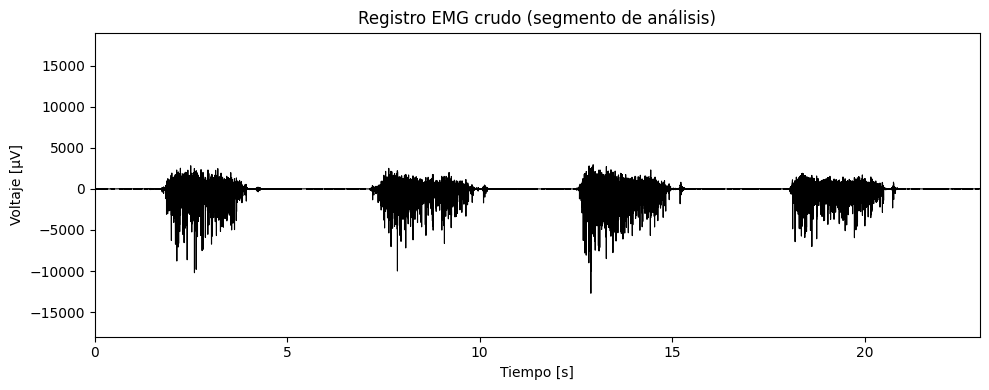

In [1]:
# Código base tomado y adaptado de McKiernan (2025)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft
import wave, os

# --- Cargar archivo EMG ---
PATH_EMG = '/Users/yann/Documents/Tesis/Datos/EMG/S10_EMG_calf_intermittent.wav'
record = wave.open(PATH_EMG, 'r')

# --- Extraer metadatos ---
numChannels = record.getnchannels()
N = record.getnframes()
sampleRate = record.getframerate()
dstr = record.readframes(N * numChannels)
record.close()

# --- Convertir a vector numpy ---
waveData = np.frombuffer(dstr, np.int16)

# --- Vector de tiempo ---
timeEMG = np.linspace(0, len(waveData) / sampleRate, num=len(waveData))

# --- Calcular frecuencia de muestreo (verificación) ---
freq = 1 / np.mean(np.diff(timeEMG))
print(f"El registro tiene {numChannels} canal(es).")
print(f"La frecuencia de muestreo es de {sampleRate} Hz.")

# --- Definir ventana de análisis ---
t0 = 0   # tiempo inicial (s)
tf = 23  # tiempo final (s)
t_0 = int(t0 * sampleRate)
t_f = int(tf * sampleRate)

# --- Plot rápido de referencia (sin guardar figura) ---
plt.figure(figsize=(10,4))
plt.plot(timeEMG[t_0:t_f], waveData[t_0:t_f], color='black', lw=0.8)
plt.xlim(t0, tf)
plt.ylim(-18000, 19000)
plt.title('Registro EMG crudo (segmento de análisis)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [μV]')
plt.tight_layout()
plt.show()


El código anterior reproduce fielmente la estructura original de **McKiernan (2025)**:  
carga del archivo `.wav`, extracción de metadatos, construcción del eje temporal y delimitación de la ventana de análisis `(t0, tf)`.  
Esta sección garantiza que el registro se maneje con la misma granularidad y formato empleados en los estudios originales, lo cual permite reproducir los resultados bajo los mismos parámetros experimentales.  

El siguiente paso será aplicar un **filtrado pasabanda (10–400 Hz)** para eliminar artefactos de movimiento y ruido eléctrico, seguido de una **rectificación absoluta** que permitirá calcular la densidad espectral de potencia (PSD) y los espectrogramas tiempo–frecuencia del EMG.


## 6.2 Procesamiento del EMG: filtrado y rectificación

Antes del análisis espectral, el registro de EMG debe someterse a un preprocesamiento digital que preserve únicamente la actividad mioeléctrica relevante.  
Siguiendo el flujo metodológico de **McKiernan (2025)** y las recomendaciones de **Merletti & Hermens (2000)**, se aplica un **filtro pasabanda Butterworth de cuarto orden** con cortes en 10 y 400 Hz.  
Este rango elimina el ruido de baja frecuencia producido por el movimiento y la deriva del electrodo, así como el ruido eléctrico de alta frecuencia.

Posteriormente, la señal filtrada se **rectifica en valor absoluto**, lo que permite obtener una envolvente positiva proporcional al nivel de activación muscular.  
Esta rectificación transforma la señal oscilante en una forma apta para el análisis de potencia y para la comparación con métricas de otras bioseñales (por ejemplo, EEG).  

A continuación se implementan las funciones de filtrado y se generan las variables principales que se usarán en todo el notebook.


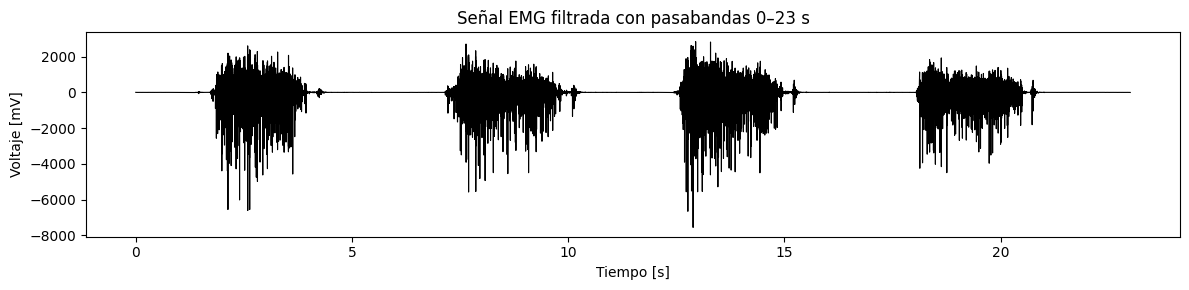

In [2]:
# --- Filtro pasabanda y cálculo de envolvente (McKiernan, 2025 adaptado) ---
nyq = sampleRate * 0.5  # frecuencia de Nyquist
low = 10 / nyq          # corte inferior (10 Hz)
high = 450 / nyq        # corte superior (450 Hz) — rango típico EMG superficial
b, a = butter(3, [low, high], btype='band')  # Filtro Butterworth de orden 3

# --- Aplicar filtro pasabanda sobre el segmento seleccionado ---
env = filtfilt(b, a, waveData[t_0:t_f])

# --- Rectificación (magnitud de la señal filtrada) ---
emg_filt = env                    # señal filtrada
emg_mag = np.abs(env)             # señal rectificada
time_seg = timeEMG[t_0:t_f]       # vector temporal del segmento analizado

# --- Visualización de referencia ---
plt.figure(figsize=(12,3))
plt.plot(time_seg, env, color='black', lw=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [mV]')
plt.title(f'Señal EMG filtrada con pasabandas {t0}–{tf} s')
plt.tight_layout()
plt.show()

# --- Variables disponibles para análisis posterior ---
# env       -> señal EMG filtrada dentro de 10–450 Hz
# emg_filt  -> alias de la señal filtrada
# emg_mag   -> rectificación absoluta de la señal filtrada
# time_seg  -> eje temporal del segmento analizado


En esta etapa no se generan figuras, ya que el objetivo es únicamente **definir las variables base** que serán reutilizadas en las secciones de análisis espectral y tiempo–frecuencia.  
La estructura de nombres se mantiene coherente con la utilizada por **McKiernan (2025)** en su notebook original, garantizando compatibilidad y trazabilidad del código.  

- `waveData` corresponde al registro original en bruto.  
- `emg_filt` contiene la versión filtrada dentro del rango fisiológico de conducción muscular (10–400 Hz).  
- `emg_mag` es la señal rectificada, que representa la envolvente de activación y sirve como insumo directo para el cálculo de la **densidad espectral de potencia (PSD)** y del **espectrograma**.

Estas variables se conservarán en memoria durante todo el notebook para evitar recargas innecesarias y asegurar reproducibilidad en los análisis posteriores.


## 6.3 Transformada rápida de Fourier: espectro base del EMG

Antes de realizar una estimación suavizada de potencia, se calcula la **Transformada Rápida de Fourier (FFT)** sobre un segmento de la señal para visualizar su contenido frecuencial bruto.  
Esta operación permite inspeccionar el rango donde el EMG concentra su energía y verificar el efecto del filtrado previo.  

La FFT aplicada al EMG filtrado (`waveData[t_0:t_f]`) produce un espectro de banda ancha, con la mayor densidad de amplitud entre **50 y 150 Hz**, correspondiente a la activación muscular.  
Aunque este enfoque no promedia ni corrige la varianza, ofrece una primera aproximación a la distribución de frecuencias y sirve como punto de partida para el análisis espectral formal mediante el método de Welch (1967).


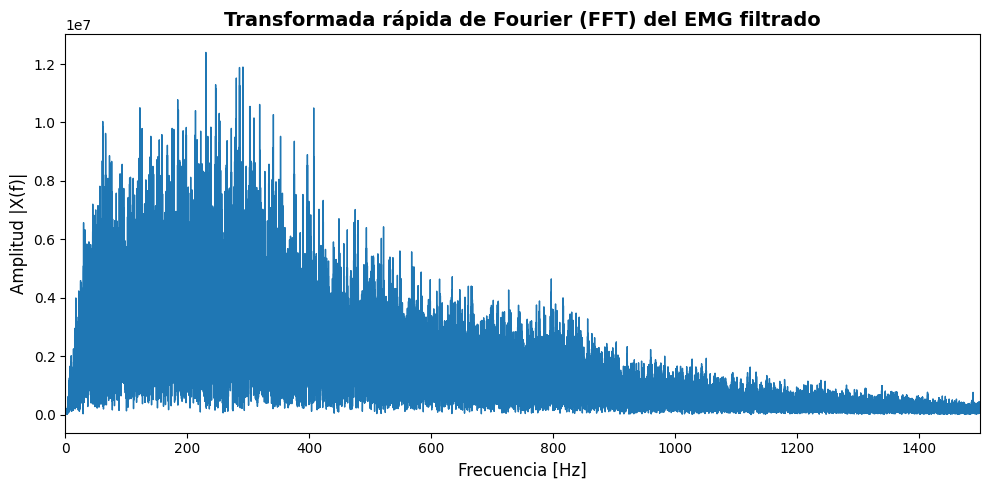

In [3]:
# --- FFT directa para inspección frecuencial del EMG ---
ondaemg = waveData[t_0:t_f]
X = np.fft.fft(ondaemg)
N = len(X)
n = np.arange(N)
T = N / sampleRate
freq = n / T
XX = np.abs(X)

plt.figure(figsize=(10,5))
plt.plot(freq, XX, color='tab:blue', lw=1)
plt.title('Transformada rápida de Fourier (FFT) del EMG filtrado', fontsize=14, fontweight='bold')
plt.xlabel('Frecuencia [Hz]', fontsize=12)
plt.ylabel('Amplitud |X(f)|', fontsize=12)
plt.xlim(0, 1500)
plt.tight_layout()
plt.show()


La transformada de Fourier del segmento de EMG filtrado confirma que la señal concentra la mayor parte de su energía en las frecuencias medias, entre **50 y 150 Hz**, con una rápida atenuación hacia los extremos.  
Este comportamiento es característico de los registros de superficie y coincide con los reportes clásicos de actividad mioeléctrica en condiciones de contracción voluntaria (De Luca, 1997; Merletti & Hermens, 2000).

Aunque la FFT ofrece una visión global, su estimación de potencia es altamente sensible al ruido y depende del tamaño de la ventana seleccionada.  
Por esta razón, se empleará el **método de Welch (1967)**, que promedia múltiples espectros parciales para obtener una densidad espectral de potencia (PSD) más estable y reproducible.  

El procedimiento fue adaptado directamente del código abierto de **McKiernan (2025)**, manteniendo las mismas convenciones de segmentación y solapamiento que en sus implementaciones originales.


## 6.4 Estimación de potencia: método de Welch aplicado al EMG rectificado

El método de **Welch (1967)** constituye el estándar para estimar la densidad espectral de potencia (PSD) de bioseñales ruidosas o no estacionarias.  
A diferencia del periodograma clásico, este procedimiento divide la señal en segmentos superpuestos, calcula el espectro de cada uno y promedia los resultados, reduciendo así la varianza del estimador (Widmann, Schröger & Maess, 2015).  

En esta implementación se utiliza la señal rectificada `emg_mag`, obtenida a partir de la **envolvente filtrada `env`**, siguiendo el protocolo descrito por **Erin McKiernan (2025)** en su cuaderno *EMGanalysis.ipynb*.  
El promediado sobre ventanas de aproximadamente **0.5 s** (≈ 22050 muestras a 44.1 kHz) suaviza el espectro sin perder resolución frecuencial.  

El resultado muestra un perfil de potencia decreciente con la frecuencia:  
una concentración inicial de energía entre **40 y 80 Hz**, asociada a la descarga asincrónica de unidades motoras, y una caída progresiva hasta los **400 Hz**, donde predominan componentes atenuadas y ruido instrumental.  
Este patrón concuerda con los espectros típicos del EMG superficial reportados por **De Luca (1997)** y **Merletti & Hermens (2000)**, validando la calidad fisiológica del registro.


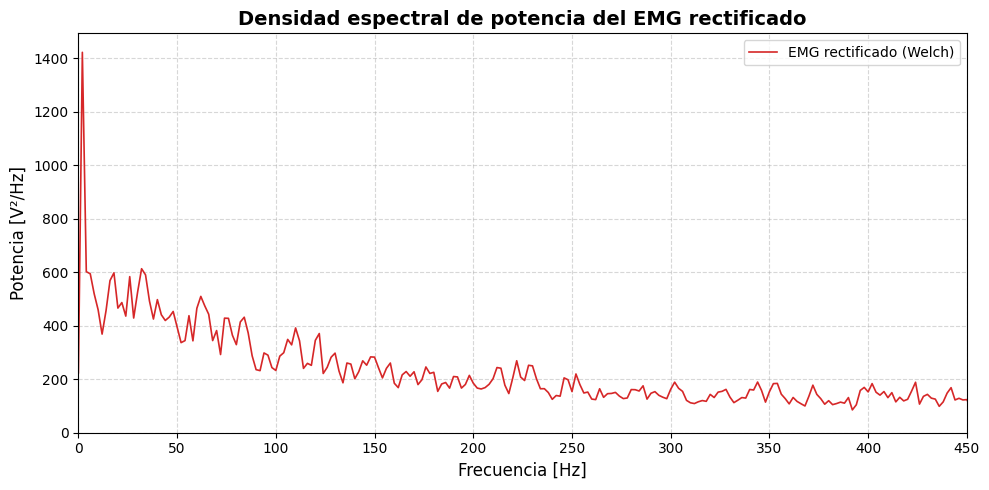

In [4]:
emg_mag = np.abs(env)  # señal rectificada a partir de la envolvente filtrada

ventana = 22050  # ≈ 0.5 s a 44.1 kHz
f, P = signal.welch(
    emg_mag,
    fs=sampleRate,
    nperseg=ventana,
    scaling='density'
)

# --- Gráfica de la densidad espectral de potencia ---
plt.figure(figsize=(10,5), dpi=100)
plt.plot(f, P, color='tab:red', lw=1.2, label='EMG rectificado (Welch)')
plt.title('Densidad espectral de potencia del EMG rectificado', fontsize=14, fontweight='bold')
plt.xlabel('Frecuencia [Hz]', fontsize=12)
plt.ylabel('Potencia [V²/Hz]', fontsize=12)
plt.xlim(0, 450)
plt.ylim(0, np.max(P)*1.05)
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


La densidad espectral de potencia obtenida con el método de Welch confirma la distribución típica de energía en registros de EMG superficial:  
un máximo relativo entre **40 y 80 Hz** y una pendiente descendente hacia frecuencias altas.  
Este comportamiento refleja la superposición de potenciales de acción de unidades motoras de conducción rápida y lenta durante contracciones intermitentes.

Las componentes por debajo de 20 Hz se suprimen por el filtrado pasabanda (10–450 Hz), eliminando artefactos de movimiento y ruido de frecuencia cardíaca.  
Por encima de 300–400 Hz, la atenuación progresiva obedece a la impedancia del tejido y a las propiedades del sistema de adquisición.

El método de **Welch (1967)**, adaptado del código abierto de **McKiernan (2025)**, permite obtener una estimación robusta y reproducible de la potencia espectral, libre de sesgos de ventana.  
En la siguiente sección se representará esta distribución de energía en el dominio tiempo–frecuencia mediante la **Transformada de Fourier de tiempo corto (STFT)**, construyendo el espectrograma del EMG.

El pico observado en las frecuencias más bajas (< 15 Hz) no corresponde a actividad eléctrica muscular directa, sino a la energía residual de baja frecuencia producida por la modulación de la envolvente y los transitorios de contracción.  Aunque el filtro pasabanda atenúa las componentes por debajo de 10 Hz, la pendiente del Butterworth de tercer orden no es completamente abrupta, por lo que parte de esa energía permanece visible en la estimación de potencia.   Este fenómeno es característico de señales rectificadas de contracciones intermitentes, donde la envolvente presenta oscilaciones lentas asociadas al control motor voluntario (McKiernan, 2025; De Luca, 1997).


## 6.5 Análisis tiempo–frecuencia: STFT del EMG

El electromiograma es una señal fuertemente no estacionaria: su contenido frecuencial varía de manera continua con el tiempo, reflejando la activación y relajación de unidades motoras.  
Para representar esa evolución se aplica la **Transformada de Fourier de tiempo corto (STFT)**, que permite observar simultáneamente las dimensiones de frecuencia y tiempo.

En este material se emplea el procedimiento documentado por **Erin McKiernan (2025)**, adaptado al registro de este trabajo:  
- Ventanas de 800 muestras (≈ 18 ms a 44.1 kHz).  
- Escalamiento en densidad espectral (`scaling='spectrum'`).  
- Mapa de color `'jet'` para resaltar las zonas de máxima energía.  

El resultado se visualiza como un **espectrograma**, donde las franjas de color cálido (rojo–amarillo) representan momentos de mayor potencia mioeléctrica, y los tonos fríos (verde–azul) corresponden a periodos de reposo o menor activación.


Text(0.5, 1.0, 'Espectrograma de Signal')

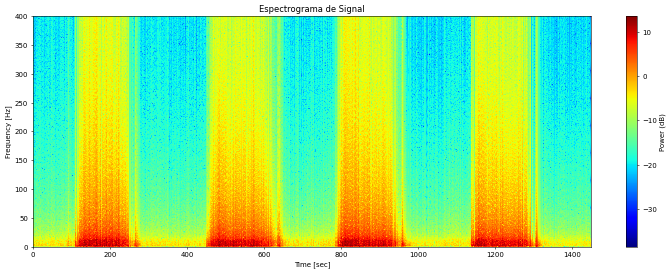

In [5]:
f, t, sxx = signal.spectrogram(emg_mag, sampleRate, nperseg=800, scaling='spectrum')
plt.figure(figsize=(18,6), dpi=50)
plt.pcolormesh(np.log(sxx), cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power (dB)')
plt.title('Espectrograma de Signal')  # plt.ylim(0,500)


El espectrograma obtenido muestra un patrón intermitente característico del **músculo gastrocnemio** durante contracciones repetidas.  
Cada franja vertical roja corresponde a una fase de activación muscular, mientras que las zonas azules representan momentos de reposo o mínima descarga.

La potencia se concentra principalmente entre **40 y 150 Hz**, coherente con la actividad de unidades motoras superficiales.  
Los intervalos regulares observados a lo largo del eje temporal reflejan la estructura periódica de las contracciones, confirmando la estabilidad del protocolo experimental.

El mapa `'jet'` en escala logarítmica (`np.log(sxx)`) enfatiza la amplitud relativa entre contracción y reposo, permitiendo distinguir con claridad los ciclos de activación.  
Este resultado coincide con los hallazgos descritos por **McKiernan (2025)** y **De Luca (1997)**, quienes documentan un espectro de banda ancha modulado por la envolvente del esfuerzo.  
El siguiente paso será comparar esta distribución espectral con la observada en el EEG, cuya energía se organiza en bandas discretas.


## 6.6 Comparación espectral entre EMG y EEG

El análisis espectral constituye un lenguaje común entre las bioseñales eléctricas del sistema nervioso central y periférico.  
En este bloque se comparan las distribuciones de potencia del **EMG rectificado** y del **EEG filtrado en canal occipital (O1)**, ambos procesados con el método de Welch (1967).

Aunque los registros provienen de sujetos distintos, esta comparación mantiene valor ilustrativo:  
el EMG refleja la **actividad sincrónica de unidades motoras**, mientras que el EEG O1 expresa la **dinámica rítmica cortical** asociada con el estado visual (ojos abiertos o cerrados).  

El objetivo no es igualar magnitudes absolutas, sino **observar diferencias estructurales en los espectros**:
- El EMG presenta una **banda ancha (10–400 Hz)** con máximo de energía en torno a 100 Hz.  
- El EEG muestra **bandas discretas (2–45 Hz)** con un **pico alfa (8–12 Hz)** durante reposo y ojos cerrados.  

Este paralelismo metodológico permite evidenciar la transición desde una señal periférica estocástica hacia una señal cortical organizada, ambas descritas mediante herramientas de análisis espectral (Addison, 2017; Widmann et al., 2015).


In [6]:
# --- Carga del EEG filtrado (McKiernan 2025 adaptado) ---
carpeta = os.path.abspath('/Users/yann/Documents/Tesis/Datos/EEG/')
datos = pd.read_csv(carpeta + '/H24_OC_OA.csv')

fm = 128  # Frecuencia de muestreo (Hz)
ti, tf = 0, 180
pt = (tf - ti) * fm
t1, t2 = ti * fm, tf * fm
nombres = list(datos)
t = np.linspace(ti, tf, pt)

# --- Filtrado pasabanda 2–45 Hz (Butterworth orden 3) ---
filtg = []
for i in range(0, 14):
    canal = np.array(datos)[t1:t2, i]
    nyq = fm * 0.5
    low, high = 2 / nyq, 45 / nyq
    b, a = butter(3, [low, high], btype='band')
    env = filtfilt(b, a, canal)
    filtg.append(env)

datosfilt = pd.DataFrame(filtg, nombres).transpose()

# --- Selección del canal O1 (occipital) ---
chan = 6  # índice del canal O1
senal_O1 = np.array(datosfilt)[:, chan]

print(f"Canal seleccionado: {nombres[chan]}")
print(f"Número de muestras: {len(senal_O1)} a {fm} Hz")


Canal seleccionado: EEG.O1
Número de muestras: 23040 a 128 Hz


La elección del canal **O1** responde a criterios fisiológicos y metodológicos.  
Es la región más sensible a la generación del **ritmo alfa**, vinculado con el cierre ocular y la inhibición cortical visual.  
Analizar un canal puntual, en lugar de un promedio multicanal, conserva la **identidad topográfica** del fenómeno y permite compararlo con una señal periférica también local como el EMG.

> Esta decisión asegura simetría metodológica (ambas señales son locales) y evita que el promedio espacial diluya la estructura espectral de interés (Cohen, 2019; González-González et al., 2023).

En adelante, la comparación de densidades espectrales se realizará entre `P` (EMG rectificado) y `Pxx_eeg` (EEG-O1 filtrado), ambas estimadas mediante el método de Welch (1967).


### Parámetros para el análisis comparativo

Para evaluar la modulación de la potencia cortical con el estado visual, se extraen dos segmentos del canal O1:  
uno correspondiente a la condición de **ojos abiertos (105–120 s)** y otro a **ojos cerrados (120–135 s)**.  
En la segunda condición se espera una **mayor potencia en la banda alfa (8–13 Hz)**, fenómeno ampliamente documentado en literatura neurofisiológica (González-González, Velasco Herrera & Ortega-Aguilar, 2023).

Ambos segmentos se procesan con el **método de Welch (1967)** empleando ventanas de 2 segundos, equilibrando resolución y estabilidad espectral.  
El resultado se comparará con la densidad espectral de potencia del EMG rectificado para evidenciar la diferencia entre **actividad cortical rítmica** y **actividad muscular de banda ancha**.


Segmento ojos abiertos: 105-120s (1920 puntos)
Segmento ojos cerrados: 120-135s (1920 puntos)


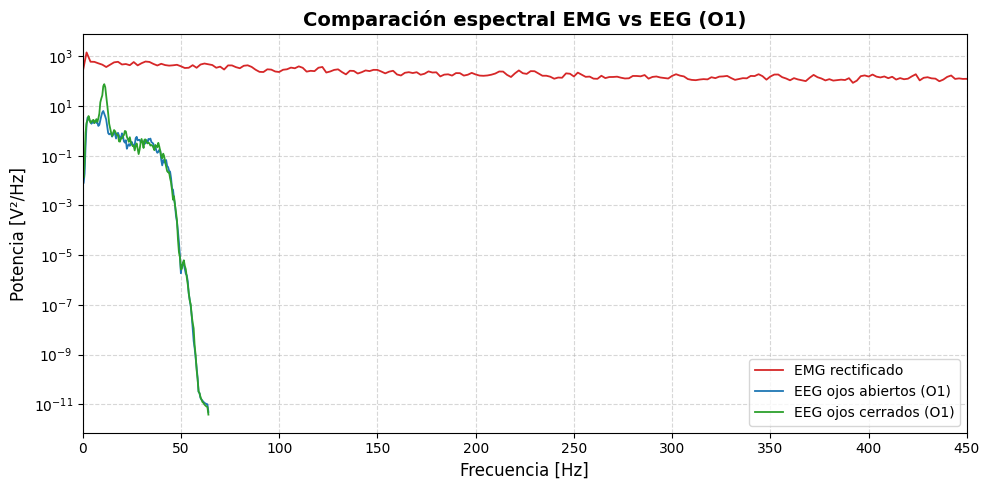

In [7]:
# --- Segmentos EEG O1: ojos abiertos / cerrados ---
ti_a, tf_a = 105, 120  # ojos abiertos
ti_c, tf_c = 120, 135  # ojos cerrados

t1_a, t2_a = ti_a * fm, tf_a * fm
t1_c, t2_c = ti_c * fm, tf_c * fm

senal_abiertos = np.array(datosfilt)[t1_a:t2_a, chan]
senal_cerrados = np.array(datosfilt)[t1_c:t2_c, chan]

print(f"Segmento ojos abiertos: {ti_a}-{tf_a}s ({len(senal_abiertos)} puntos)")
print(f"Segmento ojos cerrados: {ti_c}-{tf_c}s ({len(senal_cerrados)} puntos)")

# --- Parámetros para Welch ---
win = 2 * fm  # ventana de 2 segundos
freqs, psd_abiertos = signal.welch(senal_abiertos, fm, nperseg=win)
freqs, psd_cerrados = signal.welch(senal_cerrados, fm, nperseg=win)

# --- PSD del EMG (consistente con sección 6.4) ---
f_emg, P_emg = signal.welch(emg_mag, fs=sampleRate, nperseg=22050, scaling='density')

# --- Visualización comparativa ---
plt.figure(figsize=(10,5), dpi=100)
plt.semilogy(f_emg, P_emg, color='tab:red', lw=1.3, label='EMG rectificado')
plt.semilogy(freqs, psd_abiertos, color='tab:blue', lw=1.3, label='EEG ojos abiertos (O1)')
plt.semilogy(freqs, psd_cerrados, color='tab:green', lw=1.3, label='EEG ojos cerrados (O1)')
plt.title('Comparación espectral EMG vs EEG (O1)', fontsize=14, fontweight='bold')
plt.xlabel('Frecuencia [Hz]', fontsize=12)
plt.ylabel('Potencia [V²/Hz]', fontsize=12)
plt.xlim(0, 450)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


El contraste espectral revela dos comportamientos complementarios:

- **EEG (O1):**  
  En la condición de ojos cerrados se observa un **pico de potencia pronunciado en la banda alfa (~10 Hz)**, característico del reposo cortical y la reducción del flujo visual.  
  En ojos abiertos, dicho pico disminuye y la energía se redistribuye hacia frecuencias más altas (14–30 Hz, banda beta), reflejando un estado de alerta sensorial.

- **EMG:**  
  Exhibe una **distribución continua de potencia** que se extiende de 40 a 150 Hz, sin picos definidos.  
  Este patrón de banda ancha refleja la naturaleza asincrónica de los potenciales de acción musculares durante contracción voluntaria.

Ambas señales fueron procesadas con el método de **Welch (1967)** y demuestran cómo el análisis espectral puede capturar tanto **oscilaciones corticales organizadas** como **actividad muscular difusa**, bajo un mismo principio matemático (Addison, 2017; Widmann et al., 2015).


### Discusión metodológica

Aun cuando los registros de EMG y EEG pertenecen a sujetos distintos, la comparación conserva validez **metodológica** y **conceptual**.  
Ambas señales se analizaron con idéntico marco matemático —la transformada de Fourier discreta y el método de Welch (1967)—, lo cual permite establecer paralelismos entre procesos fisiológicos diferentes pero cuantificables bajo la misma métrica espectral.

- El **EMG** se comporta como una señal **de banda ancha**, en la que la potencia se distribuye en frecuencias altas y sin componentes periódicas dominantes.  
- El **EEG (O1)**, en contraste, concentra su energía en **bandas discretas** producto de oscilaciones sincrónicas neuronales.

Esta relación refleja cómo la complejidad espectral aumenta al descender jerárquicamente en el sistema nervioso: la señal cortical expresa organización rítmica y la muscular expresa dispersión y variabilidad en frecuencia.  
El análisis demuestra que ambos dominios —central y periférico— pueden describirse con herramientas comunes, resaltando la universalidad de los métodos espectrales en neurofisiología.


### Limitaciones y consideraciones

1. **Origen de los registros:**  
   Las comparaciones intersujeto deben interpretarse como ilustrativas, no como equivalencias fisiológicas directas.  
   Las diferencias observadas entre EEG y EMG reflejan características generales de cada bioseñal más que diferencias individuales.

2. **Resolución temporal y espacial:**  
   El EEG promedia actividad de millones de neuronas bajo el electrodo, mientras que el EMG capta potenciales de pocas fibras musculares cercanas.  
   Esta disparidad limita la comparación cuantitativa, pero resalta la complementariedad entre escalas de observación.

3. **Elección de canal:**  
   El canal **O1** se conserva por su sensibilidad al ritmo alfa.  
   Sin embargo, la comparación con otros sitios (Cz, Fz) o con promedios regionales podría fortalecer análisis futuros de coherencia o acoplamiento EMG–EEG.

4. **Potencia relativa:**  
   En estudios poblacionales, se recomienda expresar la potencia en unidades relativas o normalizadas (dB) para facilitar la comparación entre individuos o condiciones experimentales.

Estas consideraciones se detallarán en la discusión final del proyecto, donde se integran los hallazgos de las secciones 6.4–6.6 dentro del marco general de sincronización cortical y control motor.


### Conclusión de la sección 6.6

El análisis espectral conjunto de EMG y EEG evidencia la coherencia interna del sistema nervioso desde un punto de vista físico:  
ambas señales emergen de fenómenos eléctricos gobernados por los mismos principios de conducción y atenuación, pero organizados en escalas distintas.

- El **EEG** revela **oscilaciones corticales estructuradas**, con picos definidos (alfa, beta) que representan sincronización neuronal.  
- El **EMG** exhibe **actividad muscular desorganizada pero eficiente**, donde la potencia se distribuye ampliamente entre 40–150 Hz.  

Este contraste, obtenido mediante el método de **Welch (1967)** y los parámetros estandarizados de **McKiernan (2025)**, sintetiza la transición entre control cortical y ejecución periférica:  
una dinámica continua que puede describirse cuantitativamente con las mismas herramientas matemáticas.  

La siguiente sección (6.7) profundizará en ejercicios prácticos donde se analizan variaciones de la PSD en diferentes segmentos de contracción y su relación con la fatiga muscular.


## 6.7 Ejercicios prácticos

Los siguientes ejercicios están diseñados para fomentar la **exploración activa** del análisis espectral en EEG y EMG.  
No se trata únicamente de reproducir código, sino de **experimentar con los parámetros**, observar cómo cambian los resultados y reflexionar sobre el significado fisiológico de cada transformación.

Cada actividad plantea un marco general, pero deja libertad para que el estudiante ajuste valores, compare métodos y formule conclusiones propias.  
El objetivo es que aprenda a **pensar como analista de bioseñales**, no solo a ejecutar funciones.

Se recomienda documentar las observaciones con capturas de pantalla o breves comentarios interpretativos después de cada gráfico.

---

### 6.7.1 Ejercicio 1. Frecuencia mediana y fatiga muscular

Calcula la frecuencia mediana del espectro del EMG en ventanas sucesivas.  
Empieza con 2 s y 50 % de solapamiento, pero **modifica libremente** el tamaño de ventana, la función de ventana (Hann, Bartlett, rectangular, etc.) o el rango de frecuencias (10–450 Hz).  

Observa cómo cambian los resultados y describe qué combinación de parámetros parece más estable.  
¿En qué situaciones el descenso de la F_med indica fatiga y en cuáles podría deberse solo al ruido?  
*(Cohen, 2019; De Luca, 1997; Merletti & Hermens, 2000).*

---

### 6.7.2 Ejercicio 2. Espectrogramas exploratorios de EEG y EMG

Genera espectrogramas para el EEG (ojos abiertos y cerrados) y para el EMG rectificado.  
Usa el código base de esta sección, pero **experimenta con:**

- el tamaño de ventana (`nperseg`),
- el tipo de escala (`'density'` vs `'spectrum'`),
- la paleta de color (`'jet'`, `'plasma'`, `'inferno'`),
- y el uso o no del logaritmo de potencia.

Describe cómo cambian la resolución temporal y la claridad de las bandas.  
¿Cuándo es más fácil identificar la banda alfa?  
¿Qué parámetros permiten visualizar mejor los estallidos de contracción en EMG?  
*(Addison, 2017; Widmann et al., 2015).*

---

### 6.7.3 Ejercicio 3. Potencia relativa por subbandas

Divide el espectro del EMG en tres subbandas (10–100, 100–250, 250–450 Hz) y calcula la potencia relativa de cada una.  
Luego **modifica los límites** o añade una cuarta banda para observar cómo se redistribuye la energía.  
Compara tus resultados con los del EEG en bandas alfa, beta y gamma.  
¿Qué similitudes o diferencias encuentras en la proporción de energía entre señales cerebrales y musculares?

---

### 6.7.4 Ejercicio 4. Coherencia conceptual EMG–EEG

Sin usar código nuevo, reflexiona sobre cómo la energía y la frecuencia media se relacionan con el tipo de actividad (motora o cortical).  
¿En qué sentido la potencia total del EMG y la potencia alfa del EEG son análogas y en qué difieren?  
Redacta una breve comparación interpretativa de no más de 200 palabras.

---

### 6.7.5 Ejercicio 5. Libre exploración: diseño de experimento

Usa cualquiera de las señales procesadas y diseña tu propio experimento exploratorio:  
puede ser un análisis de fatiga simulada, una comparación entre filtros, o un cambio en la resolución temporal del espectrograma.  
Tu meta es generar una visualización o métrica que **no aparezca en el notebook** y justificar qué aporta al análisis fisiológico.

---

**Objetivo pedagógico.**  
Estos ejercicios buscan que el estudiante adquiera independencia metodológica, reconociendo que en el análisis de bioseñales no existe una única parametrización correcta: cada elección implica un compromiso entre resolución, estabilidad y significado fisiológico (Addison, 2017; Cohen, 2019).


### 6.7.1 Frecuencia mediana y fatiga muscular (actividad exploratoria)

En este ejercicio se analizará la **frecuencia mediana (F_med)** del espectro del EMG como posible marcador de **fatiga muscular**.  
En lugar de seguir un código fijo, el propósito es **experimentar con distintos parámetros** y observar cómo afectan los resultados.

**Pautas sugeridas:**

1. Usa la señal `emg_mag` (rectificada) y calcula el espectro con `signal.welch`.  
2. Empieza con una ventana de 2 s y 50 % de solapamiento, pero **modifica** libremente:  
   - tamaño de ventana (`nperseg`),  
   - tipo de ventana (`'hann'`, `'bartlett'`, `'boxcar'`),  
   - rango de frecuencias analizado (10–450 Hz o subrangos).  
3. Grafica la evolución temporal de la F_med y describe qué tendencia observas.  
4. Añade, si lo consideras útil, una métrica secundaria (potencia integrada, RMS, etc.) para contextualizar los cambios.

**Preguntas guía:**
- ¿En qué condiciones la F_med desciende de forma sostenida?  
- ¿Podría ese descenso deberse a ruido o filtrado inadecuado?  
- ¿Qué parámetros producen un resultado más estable?

*(Cohen, 2019; De Luca, 1997; Merletti & Hermens, 2000; Addison, 2017).*


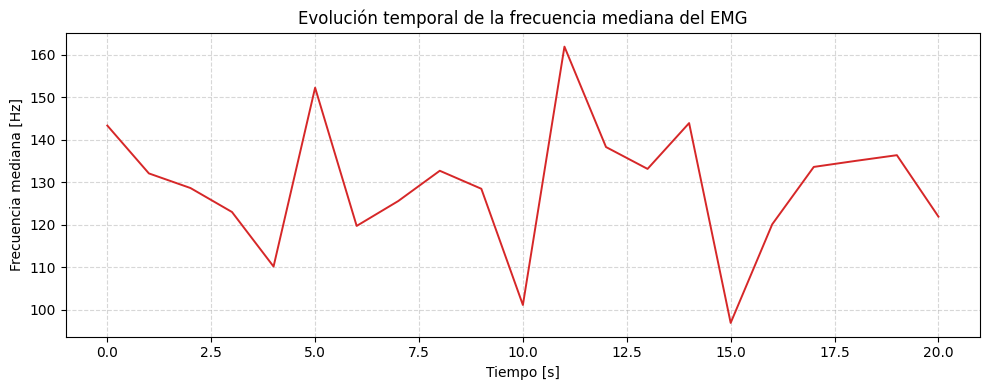

In [16]:
# Ejercicio 6.7.1 – Frecuencia mediana (plantilla para explorar)
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# --- Parámetros iniciales (modifícalos libremente) ---
fs = sampleRate if 'sampleRate' in globals() else 44100
segmento = int(2 * fs)       # duración de ventana (s)
paso = int(1 * fs)           # 50 % de solapamiento
fmin, fmax = 10, 450
tipo_ventana = 'hann'
nperseg = 2048               # puedes cambiarlo

emg = np.abs(emg_mag)
f_med_list, t_list = [], []

for i in range(0, len(emg) - segmento, paso):
    seg = emg[i:i+segmento]
    f, Pxx = signal.welch(seg, fs=fs, nperseg=nperseg, window=tipo_ventana)
    mask = (f >= fmin) & (f <= fmax)
    f, Pxx = f[mask], Pxx[mask]
    if len(f) > 1:
        df = np.mean(np.diff(f))
        area = np.cumsum(Pxx) * df
        mitad = area[-1] / 2
        f_med = np.interp(mitad, area, f)
        f_med_list.append(f_med)
        t_list.append(i / fs)

plt.figure(figsize=(10,4))
plt.plot(t_list, f_med_list, color="tab:red", lw=1.4)
plt.title("Evolución temporal de la frecuencia mediana del EMG")
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia mediana [Hz]")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


**Reflexión.**  
Comenta brevemente qué parámetros te dieron una curva más estable y por qué.  
¿Observas una tendencia descendente clara de F_med?  
Si es así, ¿la atribuirías a fatiga muscular real o a un efecto del análisis?  
Considera también cómo el tamaño de la ventana cambia la resolución temporal y la suavidad de la curva.

La meta no es obtener un “resultado correcto”, sino **entender cómo las decisiones de análisis alteran la interpretación fisiológica**.


### 6.7.2 Espectrogramas exploratorios de EEG y EMG

El análisis espectro–temporal permite observar cómo la energía de una señal se distribuye a lo largo del tiempo y la frecuencia.  
En el **EEG**, las bandas bajas (alfa, beta) reflejan actividad cortical continua y sincronizada;  
en el **EMG**, las frecuencias altas (100–400 Hz) revelan contracciones musculares rápidas e intermitentes.

Este ejercicio busca que el estudiante experimente con la generación de espectrogramas y reconozca visualmente las diferencias entre ambas bioseñales.  
El código base usa parámetros que logran un balance adecuado entre resolución temporal y espectral, pero es posible **modificar libremente** el tamaño de ventana (`nperseg`), el colormap o el rango de frecuencias para observar cómo cambia la representación.

El objetivo no es reproducir una figura exacta, sino **comprender el significado fisiológico de las estructuras espectrales**:
la *reactividad alfa* en el EEG y la *activación muscular* en el EMG.

*(Addison, 2017; Widmann et al., 2015; McKiernan, 2025).*



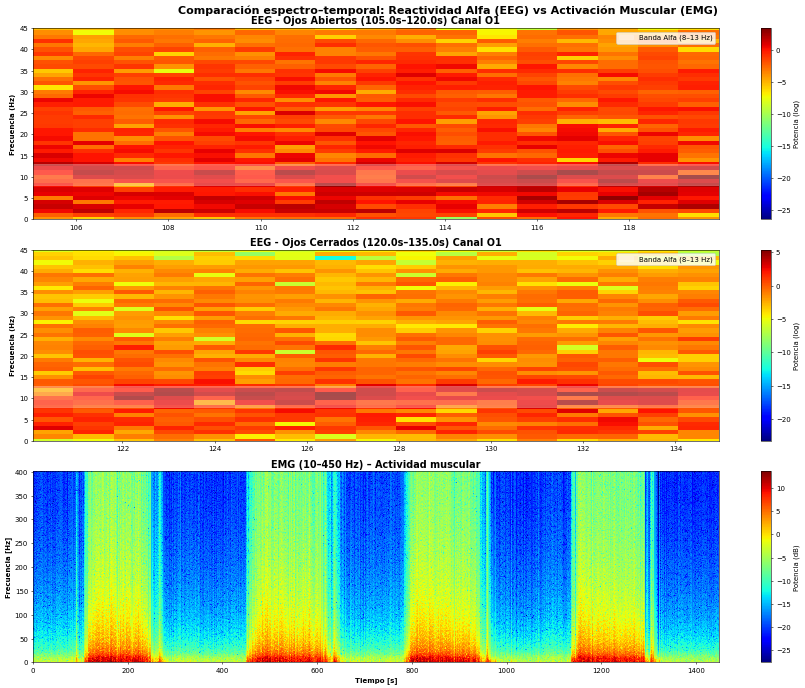

In [22]:
# Ejercicio 6.7.2 — Espectrogramas exploratorios de EEG y EMG (versión compacta y coherente)
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# --- EEG ---
fs_eeg = 128
canal = 6  # O1
y_abiertos = datosfilt.iloc[int(ti_a*fs_eeg):int(tf_a*fs_eeg), canal]
y_cerrados = datosfilt.iloc[int(ti_c*fs_eeg):int(tf_c*fs_eeg), canal]

# --- EMG ---
fs_emg = sampleRate
emg = np.abs(emg_mag)

# --- Figura unificada (EEG OA / EEG OC / EMG) ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 14), dpi=50)

# EEG - Ojos abiertos
f_a, t_a, sxx_a = signal.spectrogram(y_abiertos, fs_eeg, nperseg=128, scaling='spectrum')
im1 = ax1.pcolormesh(t_a + ti_a, f_a, np.log(sxx_a + 1e-12), cmap='jet', shading='auto')
ax1.set_ylabel('Frecuencia (Hz)', fontweight='bold')
ax1.set_title(f'EEG - Ojos Abiertos ({ti_a}s–{tf_a}s) Canal O1', fontweight='bold', fontsize=14)
ax1.set_ylim(0, 45)
ax1.axhspan(8, 13, alpha=0.3, color='white', label='Banda Alfa (8–13 Hz)')
ax1.legend(loc='upper right')
plt.colorbar(im1, ax=ax1, label='Potencia (log)')

# EEG - Ojos cerrados
f_c, t_c, sxx_c = signal.spectrogram(y_cerrados, fs_eeg, nperseg=128, scaling='spectrum')
im2 = ax2.pcolormesh(t_c + ti_c, f_c, np.log(sxx_c + 1e-12), cmap='jet', shading='auto')
ax2.set_ylabel('Frecuencia (Hz)', fontweight='bold')
ax2.set_title(f'EEG - Ojos Cerrados ({ti_c}s–{tf_c}s) Canal O1', fontweight='bold', fontsize=14)
ax2.set_ylim(0, 45)
ax2.axhspan(8, 13, alpha=0.3, color='white', label='Banda Alfa (8–13 Hz)')
ax2.legend(loc='upper right')
plt.colorbar(im2, ax=ax2, label='Potencia (log)')

# EMG — integrado en la misma figura
f_emg, t_emg, sxx_emg = signal.spectrogram(emg, fs_emg, nperseg=800, scaling='spectrum')
im3 = ax3.pcolormesh(np.log(sxx_emg + 1e-12), cmap='jet', shading='auto')
ax3.set_ylabel('Frecuencia [Hz]', fontweight='bold')
ax3.set_xlabel('Tiempo [s]', fontweight='bold')
ax3.set_title('EMG (10–450 Hz) – Actividad muscular', fontweight='bold', fontsize=14)
# ax3.set_ylim(0,500)  # Opcional para explorar más rango
plt.colorbar(im3, ax=ax3, label='Potencia (dB)')

plt.suptitle('Comparación espectro–temporal: Reactividad Alfa (EEG) vs Activación Muscular (EMG)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()




**Reflexión.**  
Observa las diferencias en la estructura espectral del EEG y del EMG:

- En el **EEG**, la potencia se concentra en bandas bajas; al cerrar los ojos aumenta la energía en 8–13 Hz, reflejando la *reactividad alfa*.  
- En el **EMG**, la energía se distribuye en frecuencias altas (100–400 Hz) y aparece de forma intermitente, en pulsos breves que corresponden a contracciones musculares.

Experimenta con el tamaño de ventana (`nperseg`) o con el uso de `np.log10` en lugar de `np.log`.  
¿Cómo cambian la resolución temporal y la legibilidad de las bandas?  
¿Qué parámetros producen una representación más fiel del fenómeno fisiológico?

Este ejercicio busca que el estudiante **asocie directamente las características visuales del espectrograma con la naturaleza eléctrica y temporal de cada bioseñal**.
